## Load Models

The code blocks below load in our face detection and classification models. We use a Haar Cascades Classifier for face detection and our trained LinearSVC Model and Encoder for face recognition. These models are either found publicly on github or located on our [fire-facenet](https://www.kaggle.com/sagars729/fire-facenet) dataset. 

In [1]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2020-05-08 15:17:37--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: ‘haarcascade_eye.xml’

haarcascade_eye.xml 100%[===================>] 333.40K  --.-KB/s    in 0.03s   

2020-05-08 15:17:37 (10.8 MB/s) - ‘haarcascade_eye.xml’ saved [341406/341406]

--2020-05-08 15:17:38--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [2]:
import numpy as np
import cv2
import os
import pickle
import sys

svc = pickle.load(open("/kaggle/input/fire-facenet/svc.pkl", "rb"))
enc = pickle.load(open("/kaggle/input/fire-facenet/encoder.pkl", "rb"))
mod = "/kaggle/input/fire-facenet/nn4.small2.v1.h5"
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

root = "/kaggle/input/asn10e-final-submission-coml-facial-recognition/"
infile = open(os.path.join(root,"person_id_mapping.csv"), "r")
person_to_id = {line.split(",")[1][:-1]:int(line.split(",")[0]) for line in infile if "person_id" not in line}
id_to_person = {person_to_id[key]:key for key in person_to_id}

sys.path.append("/kaggle/input/fire-facenet/models")
from models.face_recognition.model import create_model

nn4_small2_pretrained = create_model() # Just going to go with pretrained model for now; if we need to train it I'll paste in the relevant code
nn4_small2_pretrained.load_weights(mod)

from models.face_recognition.align import AlignDlib
alignment = AlignDlib('/kaggle/input/fire-facenet/models/models/landmarks.dat')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is no

## Detect and Classify Faces

The code below detects all faces in the input images. Cropped faces are stored in X, bounding boxes in F, and paths for the original image in X_paths.

In [3]:
paths = [i for i in os.listdir(root) if i[-3:] == "jpg"]
print(paths)
X_paths = []
X = []
F = []
for im in paths:
    impath = os.path.join(root,im)
    img = cv2.imread(impath)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    faces = alignment.getAllFaceBoundingBoxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #print(faces)
    for face in faces:
        X_paths.append(im)
        F.append((face.left(),face.top(),face.right() - face.left(),face.bottom() - face.top()))
        fx, fy, fw, fh = F[-1]
        c = img[fy:fy+fh, fx:fx+fw]
        X.append(c)
        #print(c)
X_paths = np.asarray(X_paths)
X = np.asarray(X)
F = np.asarray(F)

print(len(X))
print(len(X_paths))

['1.jpg', '0.jpg']
44
44


The code below finds the embeddings of each cropped image and predicts labels for all cropped images. 

In [4]:
import os
import tqdm
import dlib

def process_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(96,96))
    alignment.align(96, img, dlib.rectangle(0,0,95,95),landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    return img

embedded = np.zeros((X.shape[0], 128))

for i, img in enumerate(tqdm.tqdm(X)):
    img = process_image(img)
    X[i] = img
    img = (img / 255.).astype(np.float32)
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

Y = enc.inverse_transform(svc.predict(embedded))

100%|██████████| 44/44 [00:03<00:00, 13.45it/s]


## Visualize Predicted Labels

The code block below shows 20 randomly sampled cropped faces and their labels using our SVC model.

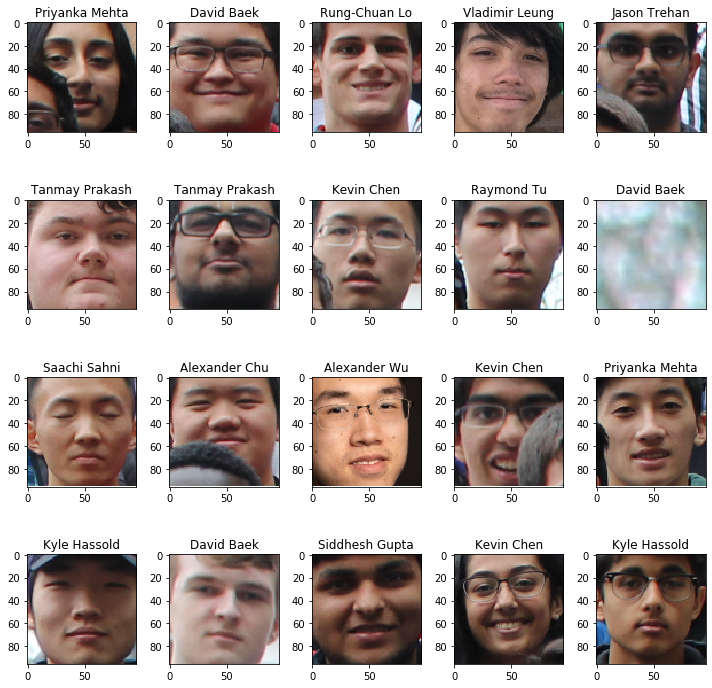

In [5]:
from matplotlib import pyplot as plt
import random

I = np.arange(len(X))
np.random.shuffle(I)
columns = 5
rows = 4
fig=plt.figure(figsize=(10, 10))
for i in range(1, columns*rows +1):
    idx = I[i-1]
    img = X[idx]#cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(Y[idx])
    plt.imshow(img)

fig.tight_layout()
plt.show()

## Assignment Matching

Since we know that each person has only one cropped image and that certain people are located in one image and certain people in another, we introduce assignment matching to optimize our accuracy. This is also a neccessary step to meet the submission requirements. 

In [6]:
ids = ["0_25", "0_34", "0_40", "0_37", "0_3", "0_2", "0_20", "0_27", "0_39", "0_33", "0_14", "0_17", "0_4", "0_46", "0_29", "0_35", "0_11", "0_41", "0_8", "0_42", "0_7", "0_1", "0_15", "0_0", "0_32", "0_16", "0_21", "0_13", "0_31", "0_30", "0_22", "0_19", "0_23", "0_24", "0_43", "0_36", "0_10", "0_44", "1_28", "1_26", "1_38", "1_45", "1_12", "1_9"]
ids0 = sorted([int(i.split("_")[1]) for i in ids if i[0] == "0"]) #Students + Dr. Tu
ids1 = sorted([int(i.split("_")[1]) for i in ids if i[0] == "1"]) #Mentors
pred = svc.decision_function(embedded)
idx0 = np.asarray([i for i in range(len(X_paths)) if "0" in X_paths[i]])
idx1 = np.asarray([i for i in range(len(X_paths)) if "1" in X_paths[i]])

### Hungarian Algorithm 

The hungarian algorithm performs assignment matching to find the least possible cost with an associated matrix. To do this we first create a cost matrix by multiplying each distance by -1 and only including distances if they belong to the people in a specific image. We then use the Munkres python package to find the optimal assignments. 

In [7]:
!pip install munkres

In [8]:
from munkres import Munkres, print_matrix
m = Munkres()

def find_labels(pred, ids):#, people):
    mat = [[-1*dist[i] for i in range(len(dist)) if i in ids] for dist in pred]
    matches = {i[0]:i[1] for i in m.compute(mat)}
    #print(matches)
    labels = [ids[matches[i]] if i in matches else None for i in range(len(pred))]
    return labels
#people = [person_to_id[j] for j in enc.inverse_transform(np.asarray([i for i in range(pred.shape[1])]))]
labels1 = find_labels(pred[idx1],ids1)
labels0 = find_labels(pred[idx0],ids0)

y2 = []
j = 0
k = 0
for i in range(len(X_paths)):
    if i in idx0: 
        y2.append(labels0[j])
        j += 1
    else:
        y2.append(labels1[k])
        k+=1
#print(y2)

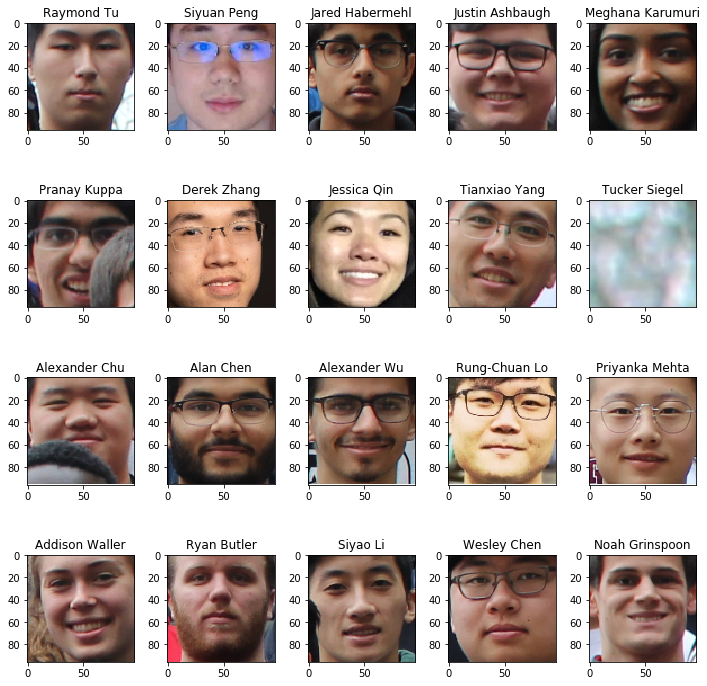

In [9]:
from matplotlib import pyplot as plt
import random

#I = np.arange(len(X))
I = np.asarray([i for i in range(len(X)) if y2[i] != None])
np.random.shuffle(I)
columns = 5
rows = 4
fig=plt.figure(figsize=(10, 10))
for i in range(1, columns*rows +1):
    idx = I[i-1]
    img = X[idx]#cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(id_to_person[y2[idx]])
    plt.imshow(img)

fig.tight_layout()
plt.show()

### Greedy Algorithm

This algorithm finds each person's best match, but doesn't assume a 1 to 1 mapping between cropped images and people. Essentially each person may only map to one image, but each image may map to multiple people. This approach may result in higher positive matches than the hungarian algorithm which may choose less optimal individual matches for a more optimal set match to preserve the 1 to 1 mapping.

In [10]:
def find_data(pnum, pred, idx):
    ind = 0
    mx = -100
    for i, p in enumerate(pred):
        if p[pnum] > mx: 
            ind = i
            mx = p[pnum]
    fname = X_paths[idx[ind]]
    fx, fy, fw, fh = F[idx[ind]]
    return {"filename": fname, "person_id":fname.replace(".jpg", "_%d"%pnum), 'xmin': fx, 'xmax': fx+fw, 'ymin': fy, 'ymax': fy+fh, 'img': idx[ind]}
        
def find_labels(pred, ids):#, people):
    mat = [[-1*dist[i] for i in range(len(dist)) if i in ids] for dist in pred]
    matches = {i[0]:i[1] for i in m.compute(mat)}
    print(matches)
    labels = [ids[matches[i]] if i in matches else None for i in range(len(pred))]
    return labels
#people = [person_to_id[j] for j in enc.inverse_transform(np.asarray([i for i in range(pred.shape[1])]))]
preds1 = pred[idx1]
preds0 = pred[idx0]

y3 = {**{pnum:find_data(pnum, preds1, idx1) for pnum in id_to_person if pnum in ids1}, **{pnum:find_data(pnum, preds0, idx0) for pnum in id_to_person if pnum in ids0}}

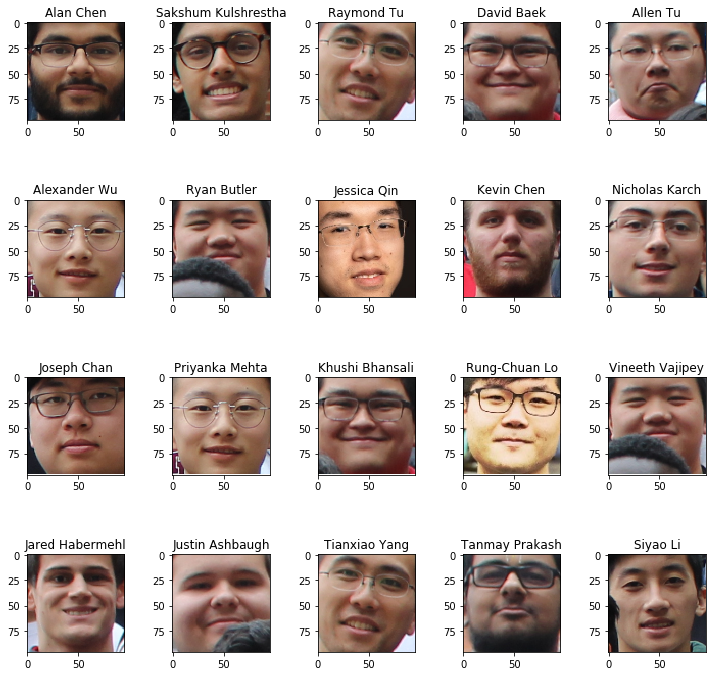

In [11]:
#I = np.arange(len(X))
#I = np.asarray([i for i in range(len(X)) if y2[i] != None])
#np.random.shuffle(I)
I = [k for k in y3]
random.shuffle(I)
I = I[:20]

columns = 5
rows = 4
fig=plt.figure(figsize=(10, 10))
for i, k in enumerate(I):
    idx = y3[k]["img"]
    img = X[idx]#cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title(id_to_person[k])
    plt.imshow(img)

fig.tight_layout()
plt.show()

## Save Classifications

In [12]:
import csv

#X_paths = X_paths[:44]
ids = ["0_25", "0_34", "0_40", "0_37", "0_3", "0_2", "0_20", "0_27", "0_39", "0_33", "0_14", "0_17", "0_4", "0_46", "0_29", "0_35", "0_11", "0_41", "0_8", "0_42", "0_7", "0_1", "0_15", "0_0", "0_32", "0_16", "0_21", "0_13", "0_31", "0_30", "0_22", "0_19", "0_23", "0_24", "0_43", "0_36", "0_10", "0_44", "1_28", "1_26", "1_38", "1_45", "1_12", "1_9"]

with open('submission.csv', 'w', newline='') as csvfile:
    fieldnames = ['filename', 'person_id', 'id', 'xmin', 'xmax', 'ymin', 'ymax']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i, p in enumerate(X_paths):
        fx, fy, fw, fh = F[i]
        ide = y2[i]#person_to_id[Y[i]]
        if ide == None: continue
        assert(p.replace(".jpg", "_%d" % ide) in ids)
        writer.writerow({'filename': p, 
                         'person_id': ide, 
                         'id': p.replace(".jpg", "_%d" % ide), 
                         'xmin': fx, 
                         'xmax': fx+fw,
                         'ymin': fy,
                         'ymax': fy+fh})
    csvfile.close()

In [13]:
import csv

#X_paths = X_paths[:44]
#ids = ["0_25", "0_34", "0_40", "0_37", "0_3", "0_2", "0_20", "0_27", "0_39", "0_33", "0_14", "0_17", "0_4", "0_46", "0_29", "0_35", "0_11", "0_41", "0_8", "0_42", "0_7", "0_1", "0_15", "0_0", "0_32", "0_16", "0_21", "0_13", "0_31", "0_30", "0_22", "0_19", "0_23", "0_24", "0_43", "0_36", "0_10", "0_44", "1_28", "1_26", "1_38", "1_45", "1_12", "1_9"]

with open('submission_greedy.csv', 'w', newline='') as csvfile:
    fieldnames = ['filename', 'person_id', 'id', 'xmin', 'xmax', 'ymin', 'ymax']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for k in y3:
        writer.writerow({'filename': y3[k]["filename"], 
                         'person_id': k, 
                         'id': y3[k]["person_id"], 
                         'xmin': y3[k]["xmin"], 
                         'xmax': y3[k]["xmax"],
                         'ymin': y3[k]["ymin"],
                         'ymax': y3[k]["ymax"]})
    csvfile.close()